In [7]:
#FUNÇÃO PARA LIMPAR RESULTADOS
import numpy as np

def clear_results(valores, tol=1e-5):
    valores = np.array(valores)
    valores[np.abs(valores) < tol] = 0
    return valores

In [8]:
#BIBLIOTECAS
import numpy as np
from roboticstoolbox import ET, ERobot, Link, mstraj
from spatialmath import SE3
import sympy
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Resgatando os parâmetros do cookbot:
from parametros_cookbot import cookbot


In [10]:
# ANÁLISE SINGULARIDADES
from roboticstoolbox import jsingu
import sympy as sp

#variáveis simbólicas
q0, q1, q2 = sp.symbols('q0 q1 q2')
pos_sim = (q0, q1, q2)

#definindo a cinemática direta simbólica
TE = cookbot.fkine([q0, q1, q2])
print("A cinemática direta simbólica é:")
print(TE)

#componente translacional do end-effector
p = TE.t

#definindo as variáveis simbólicas para o jacobiano
q = pos_sim

#definindo o jacobiano simbólico
J = sp.Matrix(p).jacobian(q)
print("O Jacobiano simbólico é:")
print(J)
print(sp.Matrix.rank(J))
detJ = J.det()
print("O Determinante do Jacobiano é:", detJ)
# Valores de q1 que geram singularidades

solq1 = sp.solve(detJ, q1)
print("Valores de q1 que geram singularidades:", solq1) # disso vemos que q1 não gera singularidades!
solq2 = sp.solve(detJ, q2)
print("Valores de q2 que geram singularidades:", solq2)  


A cinemática direta simbólica é:
  0.5*sin(q1)*sin(q2) + 0.866025403784439*cos(q1) -1.0*sin(q1)*cos(q2) 0.866025403784439*sin(q1)*sin(q2) - 0.5*cos(q1) 0.0687021685740842*sin(q1)*sin(q2) + 0.676995646560476*cos(q1)  
  0.866025403784439*sin(q1) - 0.5*sin(q2)*cos(q1) 1.0*cos(q1)*cos(q2) -0.5*sin(q1) - 0.866025403784439*sin(q2)*cos(q1) 0.676995646560476*sin(q1) - 0.0687021685740842*sin(q2)*cos(q1)  
  0.5*cos(q2)  1.0*sin(q2)  0.866025403784439*cos(q2) 1.0*q0 + 0.0687021685740842*cos(q2) + 0.3  
  0            0            0            1.00000000000000  

O Jacobiano simbólico é:
Matrix([[0, -0.676995646560476*sin(q1) + 0.0687021685740842*sin(q2)*cos(q1), 0.0687021685740842*sin(q1)*cos(q2)], [0, 0.0687021685740842*sin(q1)*sin(q2) + 0.676995646560476*cos(q1), -0.0687021685740842*cos(q1)*cos(q2)], [1.00000000000000, 0, -0.0687021685740842*sin(q2)]])
3
O Determinante do Jacobiano é: -0.00471998796678188*sin(q1)**2*sin(q2)*cos(q2) - 0.00471998796678188*sin(q2)*cos(q1)**2*cos(q2)
Valores de q

POS0: [ 0.67699565 -0.01193001  0.36765843]
POS1: [0.01193001 0.67699565 0.53765843]
POS2: [4.14540276e-17 6.76995647e-01 3.68702169e-01]
POS3: [0.01193001 0.67699565 0.45765843]
POS4: [-0.67699565  0.01193001  0.53765843]
POS5: [-0.67699565 -0.06765843  0.31193001]
Vetor de posições: [[0.         0.         0.17453293]
 [0.17       1.57079633 0.17453293]
 [0.         1.57079633 0.        ]
 [0.09       1.57079633 0.17453293]
 [0.17       3.14159265 0.17453293]
 [0.         3.14159265 4.88692191]]


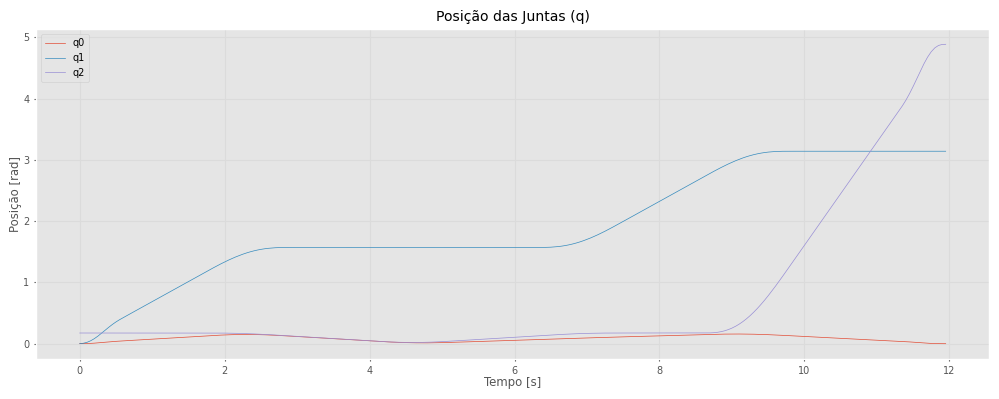

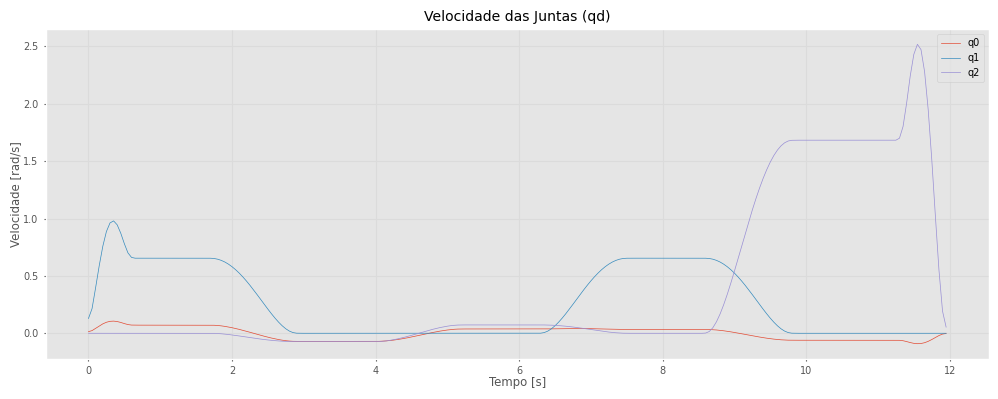

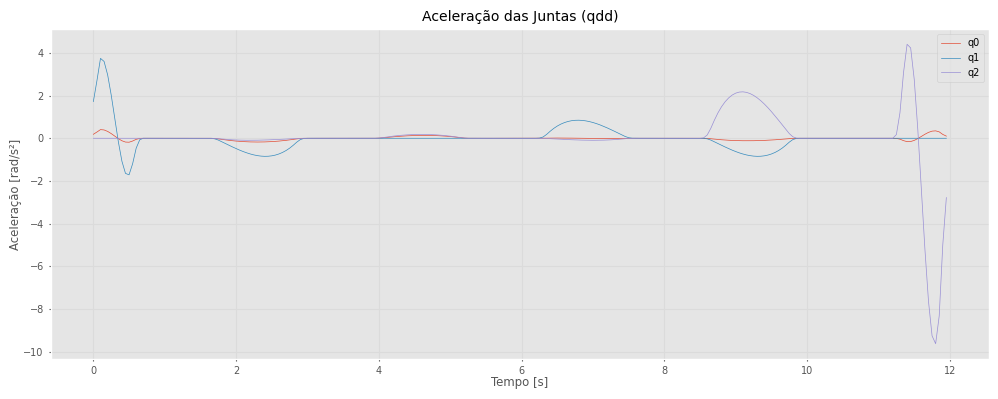

In [11]:
#TRAJETÓRIA IDEAL
#TRAJETÓRIAS
frit = 10
despfrit = 280
#batatas serão despejadas na bandeja
POS0 = cookbot.fkine([0, 0, np.deg2rad(frit)])
print("POS0:", POS0.t)
#posição 1: batatas acima da fritadeira
POS1 = cookbot.fkine([0.17, np.pi/2, np.deg2rad(frit)])
print("POS1:", POS1.t)
#posição 2: batatas  dentro da fritadeira
POS2 = cookbot.fkine([0, np.pi/2, 0])
print("POS2:", POS2.t)
#posição 3: retirar as batatas da fritadeira
POS3 = cookbot.fkine([0.09, np.pi/2, np.deg2rad(frit)])
print("POS3:", POS3.t)
#posição 4: batatas acima da bandeja de despejo
POS4 = cookbot.fkine([0.17, np.pi, np.deg2rad(frit)])
print("POS4:", POS4.t)
#posição 5: despejar as batatas na bandeja
POS5 = cookbot.fkine([0, np.pi, np.deg2rad(despfrit)])
print("POS5:", POS5.t)

#Crinado um vetor com as posições
viapoints = np.array([
    [0, 0, np.deg2rad(frit)],                       # POS0
    [0.17, np.pi/2, np.deg2rad(frit)],              # POS1
    [0, np.pi/2, 0],                                # POS2
    [0.09, np.pi/2, np.deg2rad(frit)],              # POS3
    [0.17, np.pi, np.deg2rad(frit)],                # POS4
    [0, np.pi, np.deg2rad(despfrit)],               # POS5
])
print("Vetor de posições:", viapoints)
#vetor com os tempos de cada segmento

traj_final = mstraj(
    viapoints=viapoints, 
    dt=0.05, 
    tacc=1.2, 
    qdmax = 3
)

#VELOCIDADE E ACELERAÇÃO DAS JUNTAS

t = traj_final.t  # Tempo da trajetória
q = traj_final.q  # Posições das juntas

# Derivada numérica para obter velocidade
qd = np.gradient(q, t, axis=0)

# Derivada numérica para obter aceleração
qdd = np.gradient(qd, t, axis=0)

# PLOT DOS GRÁFICOS

# Plot das posições (q)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, q[:, i], label=f'q{i}')
plt.title('Posição das Juntas (q)')
plt.xlabel('Tempo [s]')
plt.ylabel('Posição [rad]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot das velocidades (qd)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, qd[:, i], label=f'q{i}')
plt.title('Velocidade das Juntas (qd)')
plt.xlabel('Tempo [s]')
plt.ylabel('Velocidade [rad/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot das acelerações (qdd)
plt.figure(figsize=(10,4))
for i in range(q.shape[1]):
    plt.plot(t, qdd[:, i], label=f'q{i}')
plt.title('Aceleração das Juntas (qdd)')
plt.xlabel('Tempo [s]')
plt.ylabel('Aceleração [rad/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



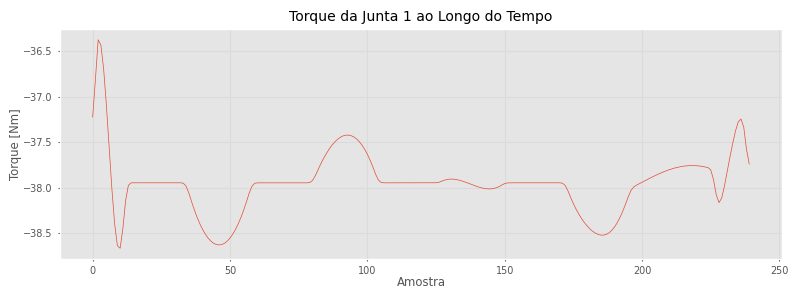

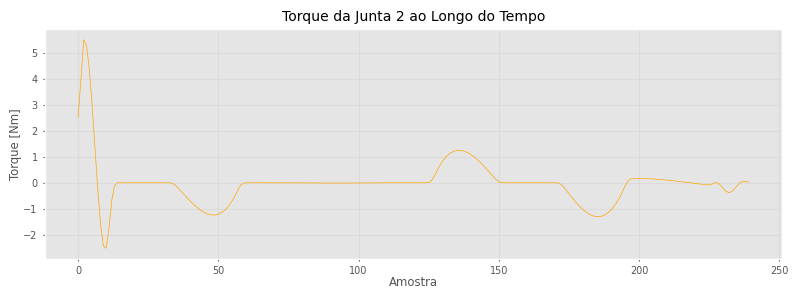

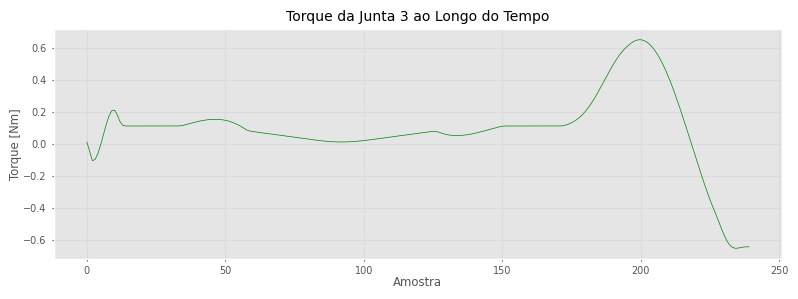

In [12]:
#PLOTS DE TORQUE IDEAL

# Cálculo do torque ideal usando a função rne (Robotic Newton-Euler)
g = 9.81

Qtraj = cookbot.rne(q, qd, qdd, gravity=[0, 0, g], symbolic=False)

t = np.arange(Qtraj.shape[0])  # vetor de tempo (amostras)

# Junta 1    
plt.figure(figsize=(8, 3))
plt.plot(t, Qtraj[:, 0], label='Torque Junta 1')
plt.xlabel('Amostra')
plt.ylabel('Torque [Nm]')
plt.title('Torque da Junta 1 ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

# Junta 2
plt.figure(figsize=(8, 3))
plt.plot(t, Qtraj[:, 1], label='Torque Junta 2', color='orange')
plt.xlabel('Amostra')
plt.ylabel('Torque [Nm]')
plt.title('Torque da Junta 2 ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()

# Junta 3
plt.figure(figsize=(8, 3))
plt.plot(t, Qtraj[:, 2], label='Torque Junta 3', color='green')
plt.xlabel('Amostra')
plt.ylabel('Torque [Nm]')
plt.title('Torque da Junta 3 ao Longo do Tempo')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()
